In [8]:
import pandas as pd
import os

df_match = pd.read_csv('ftn+_age_match_20201224-Copy1.csv',sep=',')
print(len(df_match))

fs=os.listdir('../../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/')


df_match['NRS_time']=pd.to_datetime(df_match['NRS_time'])
df_match = df_match.rename(columns={'Unnamed: 0':'index'})
#df_match.reset_index(inplace=True, drop=True)

print(len(df_match))
'''vital -> csv
df_match['path']=[f_name.split('.')[0]+".csv" for f_name in df_match['path'].values.flatten()] '''

nonlist=[]
yeslist=[]

for i in range(len(df_match)):
    filename = str(df_match.loc[i,'Value'])+','+str(df_match.loc[i,'index'])+','+ df_match.loc[i,'path']
    if not os.path.exists('../../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/'+filename):
        nonlist.append(df_match.loc[i,'path'])
    else:
        yeslist.append(df_match.loc[i,'path'])
        
len(fs), len(nonlist),len(yeslist)

10156
10156


(10075, 81, 10075)

In [48]:
import pandas as pd
import datetime
import time
import pickle
import os
import numpy as np
import vitaldb


In [5]:
os.listdir('../../../cranberry2/Preprocessing/cache/lowess_filtered/preprocess5')

['pacu_PACU1_9_200526_103443.csv_53',
 'pacu_PACU1_7_200731_115208.csv_44',
 'pacu_PACU1_1_200316_142111.csv_32',
 'pacu_PACU1_6_200916_160020.csv_37',
 'pacu_PACU1_3_200918_005602.csv_47',
 'pacu_PACU1_9_200909_130901.csv_50',
 'pacu_PACU1_4_200116_202919.csv_32',
 'pacu_PACU1_1_200123_095225.csv_25',
 'pacu_PACU1_2_190530_125626.csv_30',
 'pacu_PACU1_4_200707_102804.csv_45',
 'pacu_PACU1_3_190505_210427.csv_36',
 'pacu_PACU1_3_200320_100627.csv_55',
 'pacu_PACU1_12_190704_164600.csv_26',
 'pacu_PACU1_3_190719_193136.csv_31',
 'pacu_PACU1_3_200320_100627.csv_41',
 'pacu_PACU1_3_200228_191312.csv_47',
 'pacu_PACU1_1_201007_152611.csv_30',
 'pacu_PACU1_5_190708_180445.csv_43',
 'pacu_PACU1_1_200916_091557.csv_27',
 'pacu_PACU1_12_200108_175852.csv_28',
 'pacu_PACU1_2_200811_112256.csv_42',
 'pacu_PACU1_10_200703_114714.csv_44',
 'pacu_PACU1_4_200717_114619.csv_34',
 'pacu_PACU1_6_200218_170715.csv_39',
 'pacu_PACU1_10_190513_122929.csv_39',
 'pacu_PACU1_5_201013_091903.csv_27',
 'pacu_P

# ECG 250Hz pickle로 저장하기

In [13]:
! rm -rf 'vital_data/PPG_100Hz_ECG_100Hz_pacu_5min'

In [7]:
df_match = pd.read_csv('ftn+_age_match_20201224-Copy1.csv',sep=',')
df_match['NRS_time']=pd.to_datetime(df_match['NRS_time'])
df_match = df_match.rename(columns={'Unnamed: 0':'index'})
#df_match.reset_index(inplace=True, drop=True)

print(len(df_match))

srate= 100
for i in range(len(df_match)):
    filename = str(df_match.loc[i,'Value'])+','+str(df_match.loc[i,'index'])+','+ df_match.loc[i,'path']
    if not os.path.exists('../../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/'+filename):
        print(i, end=' ')
        #try: 
        rec_path = '../../../cranberry2/Preprocessing/vital_data/pacu_ecg_pleth/pacu_ecg_pleth/'+df_match.loc[i,'path']
        #print(rec_path)
        #print('1')
        vfile_ecg = vitaldb.vital_recs_time(rec_path,['SNUADCW/ECG_II'],interval=0.01).flatten()
        vfile_ppg = vitaldb.vital_recs_time(rec_path,['SNUADCW/PLETH'],interval=0.01).flatten()
        
        #print(vfile)
        if len(vfile_ecg[0])==0 | len(vfile_ppg[0])==0:
            print('index ',df_match.loc[i,'index'],' OPID ',df_match.loc[i,'opid'],'empty vital file')
        else:
            Abs_time = [vfile_ecg[1]+datetime.timedelta(hours=9)+datetime.timedelta(seconds=i/srate) for i in range(len(vfile_ecg[0]))]
            #print(vfile[1])
            dics = {'Abs_time':Abs_time,'PPG':vfile_ppg[0],'ECG':vfile_ecg[0]}
            df_vital = pd.DataFrame(data=dics)
            end_idx_list = df_vital[(df_vital['Abs_time'] > df_match.loc[i,'NRS_time'] - datetime.timedelta(seconds=1)) & (df_vital['Abs_time'] < df_match.loc[i,'NRS_time'] + datetime.timedelta(seconds=1))].index.tolist()

            if len(end_idx_list)==0:
                print('index ',i,' OPID ',df_match.loc[i,'opid']," no vital data at NRS time")

            else:
                end_idx=end_idx_list[0]+1
                start_idx= end_idx - 5 * 60 * srate
                start_idx_n = max(0,start_idx)


                ext = df_vital[start_idx_n:end_idx]
                extr=ext.dropna(subset=['ECG'])
                extr=extr.drop_duplicates(subset=['ECG'])

                if len(extr)>1:
                    if start_idx <0 :
                        fit = (-1)*end_idx 
                        extraction = pd.DataFrame(index=range(5*60*srate),columns=['Abs_time','PPG','ECG'])
                        extraction[fit:]=ext
                        

                    else:
                        extraction = ext
                    with open('../../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/'+filename,'wb') as f:
                        pickle.dump(extraction, f)
                    print('...done')
        #except:
            #print('error: ',i,df_match.loc[i,'opid'],df_match.loc[i,'path'])

10156
9 ...done
23 ...done
27 ...done
37 ...done
45 ...done
47 ...done
60 ...done
70 ...done
75 ...done
81 ...done
83 ...done
84 ...done
85 86 ...done
87 94 98 101 ...done
103 111 ...done
112 ...done
113 ...done
114 116 117 120 144 ...done
154 ...done
156 ...done
157 ...done
160 ...done
166 ...done
169 ...done
174 ...done
175 ...done
176 ...done
177 ...done
186 ...done
192 ...done
199 ...done
205 ...done
206 ...done
210 ...done
214 ...done
233 ...done
242 ...done
247 ...done
249 ...done
251 ...done
254 ...done
256 ...done
260 ...done
261 ...done
265 ...done
266 ...done
274 ...done
277 ...done
279 ...done
282 ...done
288 ...done
293 ...done
298 ...done
299 ...done
301 ...done
319 ...done
327 ...done
341 ...done
343 ...done
344 ...done
349 ...done
350 ...done
353 ...done
355 ...done
361 ...done
368 ...done
370 372 374 ...done
375 ...done
379 ...done
382 ...done
385 ...done
388 ...done
391 ...done
395 398 ...done
403 ...done
404 ...done
406 ...done
418 ...done
425 ...done
426 ...done
427 

## 오류 해결해서 다시 돌리기

In [58]:
np.nanmean(vfile_ecg[0]), np.nanmean(vfile_ppg[0])

(-4.999302860390366, -184.66878893586005)

In [68]:
import os
from datetime import datetime


new = []
standard = datetime.strptime('20201227-3', '%Y%m%d-%H')
pickle_dir = '../../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min'
for file in os.listdir(pickle_dir):
    mtime = os.path.getmtime(os.path.join(pickle_dir, file))
    mtime = datetime.fromtimestamp(mtime)
    if mtime > standard:
        new.append(file)
        print('new file', file)
        
print('\n\n{} 에 오늘 수정된 파일 수: {}'.format(pickle_dir, len(new)))

pickle.dump(new, open('../201227_modified_vital','wb'))

new file 3.0,5654,PACU1_3_200604_180441.vital
new file 5.0,2038,PACU1_3_190902_160501.vital
new file 5.0,1883,PACU1_7_190827_182001.vital
new file 4.0,8963,PACU1_2_190828_105401.vital
new file 7.0,8990,PACU1_4_190902_133811.vital
new file 6.0,1404,PACU1_3_190720_113459.vital
new file 8.0,3907,PACU1_11_200220_154810.vital
new file 4.0,2241,PACU1_3_190906_181103.vital
new file 5.0,9038,PACU1_11_190909_134919.vital
new file 4.0,2123,PACU1_5_190904_154406.vital
new file 5.0,2968,PACU1_9_200113_160255.vital
new file 7.0,1587,PACU1_12_190820_104238.vital
new file 4.0,9003,PACU1_5_190904_135714.vital
new file 4.0,6475,PACU1_11_200715_145822.vital
new file 7.0,888,PACU1_5_190617_164932.vital
new file 7.0,1753,PACU1_4_190821_183002.vital
new file 5.0,2458,PACU1_1_191018_132325.vital
new file 3.0,8916,PACU1_4_190821_144052.vital
new file 5.0,2339,PACU1_7_190911_092247.vital
new file 8.0,3081,PACU1_5_200116_181354.vital
new file 8.0,8049,PACU1_9_201016_111800.vital
new file 3.0,2291,PACU1_2_19091

new file 5.0,2393,PACU1_7_190917_121928.vital
new file 5.0,2409,PACU1_6_190918_090331.vital
new file 2.0,3138,PACU1_1_200120_122316.vital
new file 5.0,8984,PACU1_6_190830_155845.vital
new file 7.0,4288,PACU1_9_200305_130843.vital
new file 5.0,8173,PACU1_10_201022_103506.vital
new file 7.0,1793,PACU1_3_190822_152149.vital
new file 6.0,1583,PACU1_7_190820_102636.vital
new file 6.0,8128,PACU1_3_201020_211912.vital
new file 5.0,2247,PACU1_3_190907_034902.vital
new file 5.0,1996,PACU1_11_190830_131630.vital
new file 4.0,2104,PACU1_2_190904_110057.vital
new file 8.0,3502,PACU1_12_200205_143346.vital
new file 7.0,2535,PACU1_1_191024_114315.vital
new file 6.0,2134,PACU1_4_190904_200156.vital
new file 5.0,1356,PACU1_4_190719_000130.vital
new file 5.0,1926,PACU1_3_190828_181701.vital
new file 6.0,8943,PACU1_4_190823_142709.vital
new file 4.0,5168,PACU1_3_200515_113730.vital
new file 6.0,2295,PACU1_5_190910_130631.vital
new file 7.0,2491,PACU1_3_191021_160814.vital
new file 2.0,1706,PACU1_5_19082

new file 5.0,8915,PACU1_4_190821_144052.vital
new file 8.0,2271,PACU1_1_190909_143818.vital
new file 5.0,1756,PACU1_2_190821_182822.vital
new file 6.0,5813,PACU1_3_200611_163230.vital
new file 4.0,2501,PACU1_7_191022_093516.vital
new file 4.0,7762,PACU1_4_200929_102240.vital
new file 6.0,406,PACU1_8_190514_112427.vital
new file 10.0,2042,PACU1_6_190902_170706.vital
new file 5.0,3098,PACU1_1_200117_102315.vital
new file 7.0,1963,PACU1_6_190829_162858.vital
new file 4.0,1905,PACU1_2_190828_121020.vital
new file 5.0,8895,PACU1_1_190820_130519.vital
new file 3.0,1551,PACU1_4_190816_190008.vital
new file 6.0,7958,PACU1_2_201013_014254.vital
new file 5.0,2438,PACU1_11_191017_140015.vital
new file 5.0,9012,PACU1_5_190905_113240.vital
new file 3.0,5927,PACU1_11_200616_132858.vital
new file 5.0,2427,PACU1_8_190918_164346.vital
new file 3.0,2475,PACU1_6_191021_090139.vital
new file 3.0,1730,PACU1_3_190821_151404.vital
new file 2.0,653,PACU1_9_190528_105044.vital
new file 5.0,8883,PACU1_5_190819_

new file 6.0,2190,PACU1_2_190905_190842.vital
new file 7.0,2116,PACU1_8_190904_135952.vital
new file 5.0,2306,PACU1_11_190910_142520.vital
new file 6.0,1803,PACU1_2_190822_195429.vital
new file 7.0,295,PACU1_11_190507_112917.vital
new file 5.0,1816,PACU1_3_190823_093036.vital
new file 6.0,7512,PACU1_3_200918_092853.vital
new file 7.0,2265,PACU1_7_190909_132756.vital
new file 5.0,8950,PACU1_1_190823_200839.vital
new file 6.0,1949,PACU1_3_190829_123317.vital
new file 6.0,6400,PACU1_9_200714_101746.vital
new file 4.0,2586,PACU1_9_191128_131353.vital
new file 4.0,1779,PACU1_11_190822_112025.vital
new file 7.0,1887,PACU1_2_190827_212848.vital
new file 5.0,3446,PACU1_9_200204_125335.vital
new file 4.0,2531,PACU1_12_191024_095055.vital
new file 5.0,2097,PACU1_2_190904_092158.vital
new file 5.0,516,PACU1_2_190516_142826.vital
new file 5.0,2102,PACU1_5_190904_092222.vital
new file 9.0,2448,PACU1_10_191018_112417.vital
new file 4.0,4041,PACU1_6_200225_140000.vital
new file 5.0,3652,PACU1_6_20021

In [67]:
import os
from datetime import datetime


new = []
standard = datetime.strptime('20201227-3', '%Y%m%d-%H')
pickle_dir = '../../../cranberry2/Preprocessing/cache/peaks/PPG_100Hz_pacu_5min'
for file in os.listdir(pickle_dir):
    mtime = os.path.getmtime(os.path.join(pickle_dir, file))
    mtime = datetime.fromtimestamp(mtime)
    if mtime > standard:
        new.append(file)
        print('new file', file)
        
print('\n\n{} 에 오늘 수정된 파일 수: {}'.format(pickle_dir, len(new)))

new file 3.0,5654,PACU1_3_200604_180441.vital
new file 6.0,1404,PACU1_3_190720_113459.vital
new file 8.0,3907,PACU1_11_200220_154810.vital
new file 4.0,2123,PACU1_5_190904_154406.vital
new file 5.0,2968,PACU1_9_200113_160255.vital
new file 4.0,6475,PACU1_11_200715_145822.vital
new file 7.0,888,PACU1_5_190617_164932.vital
new file 8.0,3081,PACU1_5_200116_181354.vital
new file 8.0,8049,PACU1_9_201016_111800.vital
new file 3.0,803,PACU1_12_190607_141912.vital
new file 6.0,639,PACU1_9_190527_164312.vital
new file 4.0,4261,PACU1_6_200304_150340.vital
new file 5.0,3032,PACU1_10_200115_155300.vital
new file 6.0,6786,PACU1_11_200730_144335.vital
new file 4.0,1464,PACU1_1_190723_205948.vital
new file 2.0,47,PACU1_3_190413_012948.vital
new file 5.0,3601,PACU1_5_200210_104932.vital
new file 8.0,1080,PACU1_4_190709_220323.vital
new file 3.0,3093,PACU1_5_200117_092240.vital
new file 5.0,7897,PACU1_7_201008_121756.vital
new file 5.0,5286,PACU1_5_200520_181252.vital
new file 8.0,5300,PACU1_12_200521_

new file 5.0,8674,PACU1_5_190524_134340.vital
new file 7.0,2551,PACU1_9_191113_104322.vital
new file 3.0,8113,PACU1_11_201020_133418.vital
new file 4.0,2590,PACU1_1_191202_114436.vital
new file 3.0,1013,PACU1_7_190708_094819.vital
new file 4.0,6826,PACU1_3_200731_185547.vital
new file 7.0,4819,PACU1_11_200326_134755.vital
new file 4.0,3685,PACU1_7_200213_140306.vital
new file 7.0,4768,PACU1_1_200324_180313.vital
new file 8.0,2120,PACU1_10_190904_145834.vital
new file 5.0,7777,PACU1_8_200929_165327.vital
new file 5.0,2679,PACU1_1_191230_103900.vital
new file 6.0,9789,PACU1_6_200611_164232.vital
new file 9.0,1737,PACU1_3_190821_160843.vital
new file 3.0,7170,PACU1_9_200821_103747.vital
new file 4.0,8149,PACU1_6_201021_142848.vital
new file 5.0,4247,PACU1_4_200304_111535.vital
new file 5.0,4810,PACU1_3_200325_212323.vital
new file 7.0,8231,PACU1_1_201026_141415.vital
new file 4.0,1252,PACU1_6_190717_084406.vital
new file 5.0,5089,PACU1_7_200512_172238.vital
new file 5.0,4013,PACU1_10_2002

In [78]:
datetime.now()

datetime.datetime(2020, 12, 27, 16, 51, 27, 840763)

In [84]:
import os
from datetime import datetime


new = []
standard = datetime.strptime('20201227-16', '%Y%m%d-%H')
pickle_dir = '../../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_5min'
for file in os.listdir(pickle_dir):
    mtime = os.path.getmtime(os.path.join(pickle_dir, file))
    mtime = datetime.fromtimestamp(mtime)
    if mtime > standard:
        new.append(file)
        print('new file', file)
        
print('\n\n{} 에 오늘 수정된 파일 수: {}'.format(pickle_dir, len(new)))

new file 3.0,5654,PACU1_3_200604_180441.vital
new file 5.0,2038,PACU1_3_190902_160501.vital
new file 5.0,1883,PACU1_7_190827_182001.vital
new file 4.0,8963,PACU1_2_190828_105401.vital
new file 7.0,8990,PACU1_4_190902_133811.vital
new file 6.0,1404,PACU1_3_190720_113459.vital
new file 8.0,3907,PACU1_11_200220_154810.vital
new file 4.0,2241,PACU1_3_190906_181103.vital
new file 5.0,9038,PACU1_11_190909_134919.vital
new file 4.0,2123,PACU1_5_190904_154406.vital
new file 5.0,2968,PACU1_9_200113_160255.vital
new file 7.0,1587,PACU1_12_190820_104238.vital
new file 4.0,9003,PACU1_5_190904_135714.vital
new file 4.0,6475,PACU1_11_200715_145822.vital
new file 7.0,888,PACU1_5_190617_164932.vital
new file 7.0,1753,PACU1_4_190821_183002.vital
new file 5.0,2458,PACU1_1_191018_132325.vital
new file 3.0,8916,PACU1_4_190821_144052.vital
new file 5.0,2339,PACU1_7_190911_092247.vital
new file 8.0,3081,PACU1_5_200116_181354.vital
new file 8.0,8049,PACU1_9_201016_111800.vital
new file 3.0,2291,PACU1_2_19091

new file 6.0,2134,PACU1_4_190904_200156.vital
new file 5.0,1356,PACU1_4_190719_000130.vital
new file 5.0,1926,PACU1_3_190828_181701.vital
new file 6.0,8943,PACU1_4_190823_142709.vital
new file 4.0,5168,PACU1_3_200515_113730.vital
new file 6.0,2295,PACU1_5_190910_130631.vital
new file 7.0,2491,PACU1_3_191021_160814.vital
new file 2.0,1706,PACU1_5_190821_101316.vital
new file 3.0,2315,PACU1_6_190910_161925.vital
new file 8.0,1867,PACU1_2_190827_131639.vital
new file 6.0,2214,PACU1_5_190906_115739.vital
new file 4.0,8907,PACU1_8_190821_091728.vital
new file 8.0,1480,PACU1_8_190816_110423.vital
new file 3.0,2331,PACU1_1_190911_085336.vital
new file 2.0,1312,PACU1_9_190718_130808.vital
new file 4.0,1889,PACU1_3_190827_215434.vital
new file 8.0,2268,PACU1_7_190909_132756.vital
new file 6.0,1428,PACU1_3_190723_102414.vital
new file 5.0,2251,PACU1_3_190907_221019.vital
new file 4.0,1581,PACU1_1_190820_104514.vital
new file 4.0,1860,PACU1_2_190827_113803.vital
new file 3.0,1999,PACU1_10_190830_

new file 3.0,5927,PACU1_11_200616_132858.vital
new file 5.0,2427,PACU1_8_190918_164346.vital
new file 3.0,2475,PACU1_6_191021_090139.vital
new file 3.0,1730,PACU1_3_190821_151404.vital
new file 2.0,653,PACU1_9_190528_105044.vital
new file 5.0,8883,PACU1_5_190819_134409.vital
new file 5.0,1869,PACU1_11_190827_131853.vital
new file 7.0,1983,PACU1_1_190830_085146.vital
new file 6.0,8981,PACU1_2_190830_143252.vital
new file 3.0,3296,PACU1_1_200128_132348.vital
new file 7.0,1830,PACU1_4_190823_162559.vital
new file 8.0,2398,PACU1_5_190917_141536.vital
new file 5.0,8898,PACU1_7_190820_141605.vital
new file 3.0,6419,PACU1_4_200714_135900.vital
new file 7.0,2282,PACU1_10_190909_173215.vital
new file 4.0,3979,PACU1_1_200221_172820.vital
new file 5.0,5700,PACU1_3_200607_200424.vital
new file 4.0,1048,PACU1_4_190709_112306.vital
new file 5.0,2523,PACU1_1_191023_153838.vital
new file 3.0,1350,PACU1_2_190718_192914.vital
new file 8.0,1546,PACU1_3_190816_184553.vital
new file 9.0,518,PACU1_12_190516

new file 8.0,1709,PACU1_8_190821_110201.vital
new file 6.0,8425,PACU1_6_190821_181842.vital
new file 5.0,9081,PACU1_3_190918_094635.vital
new file 5.0,1650,PACU1_7_190820_155740.vital
new file 8.0,8431,PACU1_3_190912_164443.vital
new file 8.0,1481,PACU1_1_190816_110423.vital
new file 5.0,2212,PACU1_2_190906_104722.vital
new file 7.0,886,PACU1_5_190617_125936.vital
new file 3.0,6316,PACU1_7_200707_115317.vital
new file 4.0,9061,PACU1_7_190911_163328.vital
new file 3.0,1933,PACU1_3_190829_085324.vital
new file 3.0,2524,PACU1_2_191023_161337.vital
new file 5.0,2394,PACU1_2_190917_121200.vital
new file 5.0,8921,PACU1_4_190821_155645.vital
new file 6.0,2418,PACU1_6_190918_145351.vital
new file 5.0,1697,PACU1_7_190821_091020.vital
new file 10.0,6127,PACU1_5_200625_154758.vital
new file 8.0,6958,PACU1_6_200811_113240.vital
new file 3.0,6349,PACU1_9_200708_153857.vital
new file 8.0,2470,PACU1_7_191018_165330.vital
new file 3.0,1986,PACU1_2_190830_090741.vital
new file 5.0,1600,PACU1_10_190820_

### main code

In [59]:
import pandas as pd
import datetime, time, pickle, os, vitaldb


df_match = pd.read_csv('ftn+_age_match_20201224-Copy1.csv',sep=',')
df_match['NRS_time']=pd.to_datetime(df_match['NRS_time'])
df_match = df_match.rename(columns={'Unnamed: 0':'index'})
#df_match.reset_index(inplace=True, drop=True)
#print(len(df_match))


error_list = []
srate= 100
for i in range(len(df_match)):
    filename = str(df_match.loc[i,'Value'])+','+str(df_match.loc[i,'index'])+','+ df_match.loc[i,'path']
    vital_path = '../../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/'+filename
    if os.path.exists(vital_path):
        print(i, end=' ')
        rec_path = '../../../cranberry2/Preprocessing/vital_data/pacu_full_vital/'+df_match.loc[i,'path']
        #print(rec_path)
        
        
        # vitaldb 에러에 해당되는 케이스
        df_vital = pickle.load(open(vital_path,'rb'))
        if np.nanmean(df_vital['ECG'].tolist()) > -4 and np.nanmean(df_vital['PPG'].tolist()) > - 100:
            print('already done')
            continue
        
        error_list.append(filename)
        print(df_match.loc[i,'path'], end='... ')
        vfile_ecg = vitaldb.vital_recs_time(rec_path,['SNUADCW/ECG_II'],interval=0.01).flatten()
        vfile_ppg = vitaldb.vital_recs_time(rec_path,['SNUADCW/PLETH'],interval=0.01).flatten()
        
        
        #print(vfile)
        # vital이 비어있는 경우
        if len(vfile_ecg[0])==0 | len(vfile_ppg[0])==0:
            print('index ',df_match.loc[i,'index'],' OPID ',df_match.loc[i,'opid'],'empty vital file')
            continue
        
        
        Abs_time = [vfile_ecg[1]+datetime.timedelta(hours=9)+datetime.timedelta(seconds=i/srate) for i in range(len(vfile_ecg[0]))]
        #print(vfile[1])
        dics = {'Abs_time':Abs_time,'PPG':vfile_ppg[0],'ECG':vfile_ecg[0]}
        df_vital = pd.DataFrame(data=dics)
        end_idx_list = df_vital[(df_vital['Abs_time'] > df_match.loc[i,'NRS_time'] - datetime.timedelta(seconds=1)) & (df_vital['Abs_time'] < df_match.loc[i,'NRS_time'] + datetime.timedelta(seconds=1))].index.tolist()

        if len(end_idx_list)==0:
            print('index ',i,' OPID ',df_match.loc[i,'opid']," no vital data at NRS time")

        else:
            end_idx=end_idx_list[0]+1
            start_idx= end_idx - 5 * 60 * srate
            start_idx_n = max(0,start_idx)


            ext = df_vital[start_idx_n:end_idx]
            extr=ext.dropna(subset=['ECG'])
            extr=extr.drop_duplicates(subset=['ECG'])

            
            # vital 값이 전부 nan이 아닌 경우
            if len(extr)>1:
                # vital이 NRS 측정 5분전까지 없는 경우
                if start_idx <0 :
                    fit = (-1)*end_idx 
                    extraction = pd.DataFrame(index=range(5*60*srate),columns=['PPG','ECG'])
                    
                    col_ppg = np.full(5*60*srate, np.nan)
                    col_ppg[fit:] = ext['PPG'][fit:].tolist()
                    
                    col_ecg = np.full(5*60*srate, np.nan)
                    col_ecg[fit:] = ext['ECG'][fit:].tolist()                    
                    
                    extraction['PPG'] = col_ppg
                    extraction['ECG'] = col_ecg

                else:
                    extraction = ext
  
                with open('../../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/'+filename,'wb') as f:
                    pickle.dump(extraction, f)
                print('...done')

        #except:
            #print('error: ',i,df_match.loc[i,'opid'],df_match.loc[i,'path'])

0 already done
1 already done
2 already done
3 already done
4 already done
5 already done
6 already done
7 already done
8 already done
9 already done
10 already done
11 already done
12 already done
13 already done
14 already done
15 already done
16 already done
17 already done
18 already done
19 already done
20 already done
21 already done
22 already done
23 already done
24 already done
25 already done
26 already done
27 already done
28 already done
29 already done
30 already done
31 already done
32 already done
33 already done
34 already done
35 already done
36 already done
37 already done
38 already done
39 already done
40 already done
41 already done
42 already done
43 already done
44 already done
45 already done
46 already done
47 already done
48 already done
49 already done
50 already done
51 already done
52 already done
53 already done
54 already done
55 already done
56 already done
57 already done
58 already done
59 already done
60 already done
61 already done
62 already done
63

KeyboardInterrupt: 

In [3]:
print(len(error_list))
pickle.dump(error_list, open('err1', 'wb'))

1302


In [4]:
error_list = pickle.load(open('err1', 'rb'))
for i in range(2,5):
    error_list.extend(pickle.load(open('err'+str(i), 'rb')))
    
error_list = (np.unique(error_list))
pickle.dump(error_list, open('vitaldb_error_case', 'wb'))
print(len(error_list))

1207


In [8]:
import pandas as pd
import datetime, time, pickle, os, vitaldb


df_match = pd.read_csv('ftn+_age_match_20201224-Copy1.csv',sep=',')
df_match['NRS_time']=pd.to_datetime(df_match['NRS_time'])
df_match = df_match.rename(columns={'Unnamed: 0':'index'})
#df_match.reset_index(inplace=True, drop=True)
#print(len(df_match))


error_list, error_flist = [], []
srate= 100
for i in range(len(df_match)):
    filename = str(df_match.loc[i,'Value'])+','+str(df_match.loc[i,'index'])+','+ df_match.loc[i,'path']
    vital_path = '../../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/'+filename
    if os.path.exists(vital_path):
        print(i, end=' ')
        rec_path = '../../../cranberry2/Preprocessing/vital_data/pacu_full_vital/'+df_match.loc[i,'path']
        #print(rec_path)
        
        
        # vitaldb 에러에 해당되는 케이스
        df_vital = pickle.load(open(vital_path,'rb'))
        if np.nanmean(df_vital['ECG'].tolist()) > -4 and np.nanmean(df_vital['PPG'].tolist()) > - 100:
            print('already done')
            continue
        
        error_list.append(df_match.loc[i,'path'])
        error_flist.append(filename)

0 already done
1 already done
2 already done
3 already done
4 already done
5 already done
6 already done
7 already done
8 already done
9 already done
10 already done
11 already done
12 already done
13 already done
14 already done
15 already done
16 already done
17 already done
18 already done
19 already done
20 already done
21 already done
22 already done
23 already done
24 already done
25 already done
26 already done
27 already done
28 already done
29 already done
30 already done
31 already done
32 already done
33 already done
34 already done
35 already done
36 already done
37 38 already done
39 already done
40 already done
41 already done
42 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


already done
43 already done
44 already done
45 46 already done
47 48 already done
49 already done
50 already done
51 already done
52 already done
53 already done
54 already done
55 already done
56 already done
57 already done
58 already done
59 already done
60 already done
61 already done
62 already done
63 already done
64 already done
65 already done
66 already done
67 already done
68 already done
69 already done
70 already done
71 already done
72 already done
73 already done
74 already done
75 already done
76 already done
77 already done
78 already done
79 already done
80 already done
81 already done
82 already done
83 84 86 88 already done
89 already done
90 already done
91 already done
92 already done
93 already done
95 already done
96 already done
97 already done
99 already done
100 already done
101 already done
102 already done
104 already done
105 already done
106 already done
107 already done
108 already done
109 already done
110 already done
111 already done
112 already done


579 already done
580 already done
581 already done
582 already done
583 already done
584 already done
585 already done
586 already done
587 already done
588 already done
589 already done
590 already done
591 592 already done
593 already done
595 already done
596 already done
597 already done
598 already done
600 already done
601 already done
603 already done
604 already done
605 already done
606 already done
607 already done
609 already done
610 already done
611 already done
612 already done
613 already done
614 already done
615 already done
616 already done
617 already done
618 already done
619 already done
620 already done
621 already done
622 already done
623 already done
624 625 already done
626 already done
627 already done
628 already done
629 already done
630 already done
631 already done
632 already done
633 already done
634 already done
635 636 already done
637 already done
638 already done
639 already done
640 already done
641 already done
642 already done
643 already done
64

1098 already done
1099 already done
1100 1101 already done
1102 already done
1103 already done
1104 already done
1105 already done
1106 already done
1107 already done
1108 already done
1109 already done
1110 already done
1111 already done
1112 already done
1113 already done
1114 already done
1115 already done
1116 1117 already done
1118 already done
1151 already done
1152 already done
1153 1154 already done
1155 already done
1156 already done
1157 1158 already done
1159 already done
1160 already done
1161 already done
1162 1163 1164 already done
1165 already done
1166 already done
1167 already done
1168 already done
1169 already done
1170 already done
1171 1172 already done
1173 already done
1174 already done
1175 already done
1176 already done
1177 already done
1178 already done
1179 already done
1180 already done
1181 already done
1182 already done
1183 already done
1184 already done
1185 already done
1186 already done
1187 already done
1188 already done
1189 already done
1190 alread

1630 already done
1631 already done
1632 already done
1633 already done
1634 already done
1635 already done
1636 already done
1637 already done
1638 already done
1639 already done
1640 already done
1641 1642 already done
1643 already done
1644 already done
1645 1646 already done
1647 already done
1648 already done
1649 already done
1650 already done
1651 already done
1652 already done
1653 already done
1654 already done
1655 already done
1656 already done
1657 already done
1658 already done
1659 already done
1660 already done
1661 already done
1662 already done
1663 already done
1664 already done
1665 already done
1666 already done
1667 already done
1668 already done
1669 already done
1670 already done
1671 already done
1672 already done
1673 1674 already done
1675 already done
1676 already done
1677 1678 already done
1679 already done
1680 already done
1681 already done
1682 already done
1683 already done
1684 already done
1685 already done
1686 already done
1687 already done
1688 168

2132 already done
2133 already done
2134 already done
2135 already done
2136 already done
2137 already done
2138 already done
2139 already done
2140 already done
2141 already done
2142 already done
2143 already done
2144 already done
2145 already done
2146 already done
2147 already done
2148 already done
2149 already done
2150 2151 already done
2152 already done
2153 already done
2154 already done
2155 already done
2156 already done
2157 already done
2158 already done
2159 already done
2160 already done
2161 already done
2162 already done
2163 already done
2164 already done
2165 already done
2166 already done
2167 already done
2168 already done
2169 already done
2170 already done
2171 already done
2172 already done
2173 already done
2174 already done
2175 already done
2176 2177 already done
2178 already done
2179 already done
2180 already done
2181 already done
2182 already done
2183 already done
2184 already done
2185 already done
2186 2187 already done
2188 already done
2189 already 

3098 already done
3099 already done
3100 3101 already done
3102 already done
3103 already done
3104 already done
3105 already done
3106 already done
3107 already done
3108 already done
3109 already done
3110 3111 already done
3112 already done
3113 already done
3114 already done
3115 3116 already done
3117 already done
3118 already done
3119 already done
3120 already done
3121 already done
3122 already done
3123 already done
3124 already done
3125 already done
3126 already done
3127 already done
3128 already done
3129 3130 already done
3131 already done
3132 already done
3133 already done
3134 already done
3135 already done
3136 already done
3137 already done
3138 already done
3139 already done
3140 already done
3141 already done
3142 already done
3143 already done
3144 already done
3145 already done
3146 already done
3147 already done
3148 already done
3149 already done
3150 already done
3151 already done
3152 already done
3153 already done
3154 3155 already done
3156 already done
315

3589 already done
3590 already done
3591 already done
3592 already done
3593 already done
3594 3595 already done
3596 already done
3597 already done
3598 already done
3599 already done
3600 already done
3601 already done
3602 already done
3603 already done
3604 already done
3605 already done
3606 already done
3607 already done
3608 already done
3609 already done
3610 already done
3611 3612 already done
3613 already done
3614 already done
3615 already done
3616 3617 already done
3618 already done
3619 already done
3620 already done
3621 already done
3622 already done
3623 already done
3624 already done
3625 3626 already done
3627 already done
3628 already done
3629 already done
3630 already done
3631 already done
3632 already done
3633 already done
3634 already done
3635 already done
3636 already done
3637 already done
3638 already done
3639 already done
3640 already done
3641 already done
3642 already done
3643 already done
3644 already done
3645 already done
3646 already done
3647 alr

4092 already done
4093 already done
4094 already done
4095 4096 already done
4097 already done
4098 already done
4099 4100 4101 already done
4102 4103 already done
4104 already done
4105 already done
4106 already done
4107 already done
4108 already done
4109 already done
4110 already done
4111 already done
4112 4113 already done
4114 already done
4115 already done
4116 already done
4117 already done
4118 already done
4119 already done
4120 already done
4121 already done
4122 4123 already done
4124 already done
4125 already done
4126 already done
4127 already done
4128 already done
4129 already done
4130 already done
4131 already done
4132 already done
4133 already done
4134 already done
4135 already done
4136 already done
4137 already done
4138 already done
4139 already done
4140 already done
4141 already done
4142 already done
4143 4144 already done
4145 already done
4146 already done
4147 already done
4148 already done
4149 4150 already done
4151 already done
4152 already done
4153 a

4573 already done
4574 already done
4575 already done
4576 already done
4577 already done
4578 already done
4579 already done
4580 already done
4581 already done
4582 already done
4583 already done
4584 already done
4585 already done
4586 already done
4587 already done
4588 already done
4589 already done
4590 already done
4591 already done
4592 already done
4593 already done
4594 already done
4595 already done
4596 already done
4597 already done
4598 already done
4599 already done
4600 4601 already done
4602 already done
4603 already done
4604 already done
4605 already done
4606 already done
4607 already done
4608 already done
4609 already done
4610 already done
4611 already done
4612 already done
4613 already done
4614 already done
4615 already done
4616 already done
4617 already done
4618 already done
4619 4620 already done
4621 already done
4622 already done
4623 already done
4624 already done
4625 already done
4626 already done
4627 already done
4628 already done
4629 already done


5055 already done
5056 already done
5057 5058 already done
5059 already done
5060 already done
5061 already done
5062 5063 already done
5064 already done
5065 already done
5066 already done
5067 already done
5068 already done
5069 already done
5070 already done
5071 already done
5072 already done
5073 already done
5074 already done
5075 already done
5076 already done
5077 5078 already done
5079 already done
5080 already done
5081 already done
5082 already done
5083 already done
5084 already done
5085 already done
5086 already done
5087 already done
5088 already done
5089 already done
5090 already done
5091 already done
5092 already done
5093 already done
5094 already done
5095 already done
5096 already done
5097 already done
5098 5099 already done
5100 already done
5101 already done
5102 already done
5103 already done
5104 already done
5105 already done
5106 already done
5107 5108 already done
5109 already done
5110 already done
5111 already done
5112 already done
5113 already done
511

5541 already done
5542 already done
5543 already done
5544 already done
5545 already done
5546 already done
5547 already done
5548 already done
5549 already done
5550 already done
5551 already done
5552 already done
5553 already done
5554 already done
5555 already done
5556 already done
5557 already done
5558 already done
5559 already done
5560 already done
5561 already done
5562 already done
5563 already done
5564 already done
5565 already done
5566 already done
5567 already done
5568 already done
5569 already done
5570 already done
5571 already done
5572 already done
5573 already done
5574 already done
5575 already done
5576 already done
5577 already done
5578 already done
5579 already done
5580 already done
5581 already done
5582 already done
5583 already done
5584 already done
5585 already done
5586 already done
5587 already done
5588 already done
5589 5590 already done
5591 already done
5592 already done
5593 already done
5594 already done
5595 already done
5596 already done
5597 

6021 already done
6022 already done
6023 already done
6024 already done
6025 already done
6026 already done
6027 already done
6028 already done
6029 6030 already done
6031 already done
6032 already done
6033 already done
6034 already done
6035 already done
6036 already done
6037 already done
6038 already done
6039 already done
6040 already done
6041 already done
6042 6043 already done
6044 already done
6045 already done
6046 already done
6047 already done
6048 already done
6049 already done
6050 already done
6051 already done
6052 already done
6053 already done
6054 already done
6055 already done
6056 already done
6057 6058 already done
6059 already done
6060 already done
6061 already done
6062 already done
6063 already done
6064 already done
6065 already done
6066 already done
6067 already done
6068 already done
6069 already done
6070 already done
6071 already done
6072 already done
6073 already done
6074 6075 already done
6076 already done
6077 already done
6078 already done
6079 alr

6504 already done
6505 already done
6506 already done
6507 already done
6508 already done
6509 already done
6510 already done
6511 already done
6512 6513 already done
6514 already done
6515 already done
6516 already done
6517 already done
6518 already done
6519 already done
6520 already done
6521 already done
6522 already done
6523 6524 already done
6525 already done
6526 already done
6527 6528 already done
6529 already done
6530 6531 already done
6532 already done
6533 already done
6534 already done
6535 already done
6536 already done
6537 already done
6538 already done
6539 already done
6540 already done
6541 already done
6542 already done
6543 already done
6544 already done
6545 6546 already done
6547 already done
6548 already done
6549 already done
6550 already done
6551 already done
6552 already done
6553 already done
6554 already done
6555 already done
6556 already done
6557 already done
6558 already done
6559 already done
6560 already done
6561 already done
6562 already done
656

6988 already done
6989 already done
6990 already done
6991 already done
6992 already done
6993 already done
6994 already done
6995 already done
6996 already done
6997 already done
6998 already done
6999 already done
7000 already done
7001 already done
7002 already done
7003 already done
7004 already done
7005 already done
7006 already done
7007 already done
7008 already done
7009 already done
7010 already done
7011 already done
7012 already done
7013 already done
7014 already done
7015 already done
7016 already done
7017 already done
7018 already done
7019 already done
7020 already done
7021 already done
7022 already done
7023 already done
7024 7025 already done
7026 already done
7027 already done
7028 already done
7029 already done
7030 already done
7031 already done
7032 already done
7033 already done
7034 already done
7035 already done
7036 already done
7037 already done
7038 already done
7039 7040 already done
7041 already done
7042 already done
7043 already done
7044 already done


7465 already done
7466 already done
7467 already done
7468 already done
7469 already done
7470 already done
7471 already done
7472 already done
7473 already done
7474 7475 already done
7476 already done
7477 already done
7478 already done
7479 7480 already done
7481 already done
7482 already done
7483 already done
7484 already done
7485 already done
7486 already done
7487 already done
7488 already done
7489 already done
7490 already done
7491 already done
7492 already done
7493 already done
7494 already done
7495 already done
7496 already done
7497 already done
7498 already done
7499 already done
7500 already done
7501 already done
7502 already done
7503 already done
7504 already done
7505 already done
7506 already done
7507 already done
7508 already done
7509 already done
7510 already done
7511 already done
7512 already done
7513 already done
7514 7515 already done
7516 already done
7517 already done
7518 already done
7519 already done
7520 already done
7521 already done
7522 already 

7953 already done
7954 already done
7955 already done
7956 already done
7957 already done
7958 already done
7959 already done
7960 already done
7961 already done
7962 already done
7963 already done
7964 already done
7965 already done
7966 already done
7967 already done
7968 already done
7969 already done
7970 already done
7971 already done
7972 already done
7973 already done
7974 already done
7977 already done
7978 already done
7979 already done
7980 already done
7981 already done
7982 already done
7983 already done
7984 already done
7985 already done
7986 7987 already done
7988 already done
7989 already done
7990 already done
7991 already done
7992 already done
7993 already done
7994 7995 already done
7996 already done
7997 already done
7998 already done
7999 already done
8000 already done
8001 already done
8002 already done
8003 already done
8004 8005 already done
8006 already done
8007 already done
8008 already done
8009 already done
8010 already done
8011 already done
8012 already 

8453 already done
8454 already done
8455 already done
8456 already done
8457 already done
8458 already done
8459 already done
8460 already done
8461 already done
8462 already done
8463 already done
8464 already done
8465 already done
8466 already done
8467 already done
8468 already done
8469 already done
8470 already done
8471 already done
8472 already done
8473 already done
8474 already done
8475 already done
8476 already done
8477 already done
8478 already done
8479 already done
8480 already done
8481 already done
8482 already done
8483 already done
8484 already done
8485 already done
8486 already done
8487 already done
8488 already done
8489 already done
8491 already done
8492 already done
8493 already done
8494 already done
8495 already done
8497 already done
8500 already done
8501 already done
8502 already done
8503 already done
8504 already done
8505 already done
8506 already done
8507 already done
8508 already done
8509 already done
8510 already done
8511 already done
8512 alrea

8929 already done
8930 already done
8931 already done
8932 already done
8933 already done
8934 already done
8935 already done
8936 already done
8937 already done
8938 already done
8939 already done
8940 already done
8941 already done
8942 already done
8943 already done
8944 already done
8945 already done
8946 already done
8947 already done
8948 already done
8949 already done
8950 already done
8951 already done
8952 already done
8953 already done
8954 already done
8955 already done
8956 already done
8957 already done
8958 already done
8959 already done
8960 already done
8961 already done
8962 already done
8963 already done
8964 already done
8965 already done
8966 already done
8967 already done
8968 already done
8969 already done
8970 already done
8971 already done
8972 already done
8973 already done
8974 already done
8975 already done
8976 already done
8977 already done
8978 already done
8979 already done
8980 already done
8981 already done
8982 already done
8983 already done
8984 alrea

9385 already done
9386 already done
9387 already done
9388 already done
9389 already done
9390 already done
9391 already done
9392 already done
9393 already done
9394 already done
9395 already done
9396 already done
9397 already done
9398 already done
9399 already done
9400 already done
9401 already done
9402 already done
9403 already done
9404 already done
9405 already done
9406 already done
9407 already done
9408 already done
9409 already done
9410 already done
9411 already done
9412 already done
9413 already done
9414 already done
9415 already done
9416 already done
9417 already done
9418 already done
9419 already done
9420 already done
9421 already done
9422 already done
9423 already done
9424 already done
9425 already done
9426 already done
9427 already done
9428 already done
9429 already done
9430 already done
9431 already done
9432 already done
9433 9434 already done
9435 already done
9436 already done
9437 already done
9438 already done
9439 already done
9440 already done
9441 

9847 already done
9848 already done
9849 already done
9850 already done
9851 already done
9852 already done
9853 already done
9854 already done
9855 already done
9856 already done
9857 already done
9858 already done
9859 already done
9860 already done
9861 already done
9862 already done
9863 already done
9864 already done
9865 already done
9866 already done
9867 already done
9868 already done
9869 already done
9870 already done
9871 already done
9872 already done
9873 already done
9874 already done
9875 already done
9876 already done
9877 already done
9878 already done
9879 already done
9880 already done
9881 already done
9882 already done
9883 already done
9884 already done
9885 already done
9886 already done
9887 already done
9888 already done
9889 already done
9890 already done
9891 already done
9892 already done
9893 already done
9894 already done
9895 already done
9896 already done
9897 already done
9898 already done
9899 already done
9900 already done
9901 already done
9902 alrea

In [51]:
import pandas as pd
import datetime, time, pickle, os, vitaldb


df_match = pd.read_csv('ftn+_age_match_20201224-Copy1.csv',sep=',')
df_match['NRS_time']=pd.to_datetime(df_match['NRS_time'])
df_match = df_match.rename(columns={'Unnamed: 0':'index'})
#df_match.reset_index(inplace=True, drop=True)
#print(len(df_match))


cnt=0
error_list, error_flist = [], []
srate= 100
for i in range(len(df_match)):
    filename = str(df_match.loc[i,'Value'])+','+str(df_match.loc[i,'index'])+','+ df_match.loc[i,'path']
    vital_path = '../../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_5min/'+filename
    if os.path.exists(vital_path):
        cnt+=1
        print(i, end=' ')
        rec_path = '../../../cranberry2/Preprocessing/vital_data/pacu_full_vital/'+df_match.loc[i,'path']
        #print(rec_path)
        
        
        # vitaldb 에러에 해당되는 케이스
        df_vital = pickle.load(open(vital_path,'rb'))
        if np.nanmean(df_vital['ECG'].tolist()) > -4 and np.nanmean(df_vital['PPG'].tolist()) > - 100:
            print('already done')
            continue
        
        print('ECG: {:.4f},  PPG: {:.4f}'.format(np.nanmean(df_vital['ECG'].tolist()),np.nanmean(df_vital['PPG'].tolist()))) 
        error_list.append(df_match.loc[i,'path'])
        error_flist.append(filename)
       

0 already done
1 already done
2 already done
3 already done
4 already done
5 already done
6 already done
7 already done
8 already done
9 already done
10 already done
11 already done
12 already done
13 already done
14 already done
15 already done
16 already done
17 already done
18 already done
19 already done
20 already done
21 already done
22 already done
23 already done
24 already done
25 already done
26 already done
27 already done
28 already done
29 already done
30 already done
31 already done
32 already done
33 already done
34 already done
35 already done
36 already done
37 already done
38 already done
39 already done
40 already done
41 already done
42 already done
43 already done
44 already done
45 already done
46 already done
47 already done
48 already done
49 already done
50 already done
51 already done
52 already done
53 already done
54 already done
55 already done
56 already done
57 already done
58 already done
59 already done
60 already done
61 already done
62 already done
63

505 already done
506 already done
507 already done
508 already done
509 already done
510 already done
511 already done
512 already done
513 already done
514 already done
515 already done
516 already done
517 already done
518 already done
519 already done
520 already done
521 already done
522 already done
523 already done
524 already done
525 already done
526 already done
527 already done
528 already done
529 already done
530 already done
531 already done
532 already done
533 already done
534 already done
535 already done
536 already done
537 already done
538 already done
539 already done
540 already done
541 already done
542 already done
543 already done
544 already done
545 already done
546 already done
547 already done
548 already done
549 already done
550 already done
551 already done
552 already done
553 already done
554 already done
555 already done
556 already done
557 already done
558 already done
559 already done
560 already done
561 already done
562 already done
563 already do

995 already done
996 already done
997 already done
998 already done
999 already done
1000 already done
1001 already done
1002 already done
1003 already done
1004 already done
1005 already done
1006 already done
1007 already done
1008 already done
1009 already done
1010 already done
1011 already done
1012 already done
1013 already done
1014 already done
1015 already done
1016 already done
1017 already done
1018 already done
1019 already done
1020 already done
1021 already done
1022 already done
1023 already done
1024 already done
1025 already done
1026 already done
1027 already done
1028 already done
1029 already done
1030 already done
1031 already done
1032 already done
1033 already done
1034 already done
1035 already done
1036 already done
1037 already done
1038 already done
1039 already done
1040 already done
1041 already done
1042 already done
1043 already done
1044 already done
1045 already done
1046 already done
1047 already done
1048 already done
1049 already done
1050 already do

1488 already done
1489 already done
1490 already done
1491 already done
1492 already done
1493 already done
1494 already done
1495 already done
1496 already done
1497 already done
1498 already done
1499 already done
1500 already done
1501 already done
1502 already done
1503 already done
1504 already done
1505 already done
1506 already done
1507 already done
1508 already done
1509 already done
1510 already done
1511 already done
1512 already done
1513 already done
1514 already done
1515 already done
1516 already done
1517 already done
1518 already done
1519 already done
1520 already done
1521 already done
1522 already done
1523 already done
1524 already done
1525 already done
1526 already done
1527 already done
1528 already done
1529 already done
1530 already done
1531 already done
1532 already done
1533 already done
1534 already done
1535 already done
1536 already done
1537 already done
1538 already done
1539 already done
1540 already done
1541 already done
1542 already done
1543 alrea

1959 already done
1960 already done
1961 already done
1962 already done
1963 already done
1964 already done
1965 already done
1966 already done
1967 already done
1968 already done
1969 already done
1970 already done
1971 already done
1972 already done
1973 already done
1974 already done
1975 already done
1976 already done
1977 already done
1978 already done
1979 already done
1980 already done
1981 already done
1982 already done
1983 already done
1984 already done
1985 already done
1986 already done
1987 already done
1988 already done
1989 already done
1990 already done
1991 already done
1992 already done
1993 already done
1994 already done
1995 already done
1996 already done
1997 already done
1998 already done
1999 already done
2000 already done
2001 already done
2002 already done
2003 already done
2004 already done
2005 already done
2006 already done
2007 already done
2008 already done
2009 already done
2010 already done
2011 already done
2012 already done
2013 already done
2014 alrea

2433 already done
2434 already done
2435 already done
2436 already done
2437 already done
2438 already done
2439 already done
2440 already done
2441 already done
2442 already done
2443 already done
2444 already done
2445 already done
2446 already done
2447 already done
2448 already done
2449 already done
2450 already done
2451 already done
2452 already done
2453 already done
2454 already done
2455 already done
2456 already done
2457 already done
2458 already done
2459 already done
2460 already done
2461 already done
2462 already done
2463 already done
2464 already done
2465 already done
2466 already done
2467 already done
2468 already done
2469 already done
2470 already done
2471 already done
2472 already done
2473 already done
2474 already done
2475 already done
2476 already done
2477 already done
2478 already done
2479 already done
2480 already done
2481 already done
2482 already done
2483 already done
2484 already done
2485 already done
2486 already done
2487 already done
2488 alrea

2890 already done
2891 already done
2892 already done
2893 already done
2894 already done
2895 already done
2896 already done
2897 already done
2898 already done
2899 already done
2900 already done
2901 already done
2902 already done
2903 already done
2904 already done
2905 already done
2906 already done
2907 already done
2908 already done
2909 already done
2910 already done
2911 already done
2912 already done
2913 already done
2914 already done
2915 already done
2916 already done
2917 already done
2918 already done
2919 already done
2920 already done
2921 already done
2922 already done
2923 already done
2924 already done
2925 already done
2926 already done
2927 already done
2928 already done
2929 already done
2930 already done
2931 already done
2932 already done
2933 already done
2934 already done
2935 already done
2936 already done
2937 already done
2938 already done
2939 already done
2940 already done
2941 already done
2942 already done
2943 already done
2944 already done
2945 alrea

3349 already done
3350 already done
3351 already done
3352 already done
3353 already done
3354 already done
3355 already done
3356 already done
3357 already done
3358 already done
3359 already done
3360 already done
3361 already done
3362 already done
3363 already done
3364 already done
3365 already done
3366 already done
3367 already done
3368 already done
3369 already done
3370 already done
3371 already done
3372 already done
3373 already done
3374 already done
3375 already done
3376 already done
3377 already done
3378 already done
3379 already done
3380 already done
3381 already done
3382 already done
3383 already done
3384 already done
3385 already done
3386 already done
3387 already done
3388 already done
3389 already done
3390 already done
3391 already done
3392 already done
3393 already done
3394 already done
3395 already done
3396 already done
3397 already done
3398 already done
3399 already done
3400 already done
3401 already done
3402 already done
3403 already done
3404 alrea

3822 already done
3823 already done
3824 already done
3825 already done
3826 already done
3827 already done
3828 already done
3829 already done
3830 already done
3831 already done
3832 already done
3833 already done
3834 already done
3835 already done
3836 already done
3837 already done
3838 already done
3839 already done
3840 already done
3841 already done
3842 already done
3843 already done
3844 already done
3845 already done
3846 already done
3847 already done
3848 already done
3849 already done
3850 already done
3851 already done
3852 already done
3853 already done
3854 already done
3855 already done
3856 already done
3857 already done
3858 already done
3859 already done
3860 already done
3861 already done
3862 already done
3863 already done
3864 already done
3865 already done
3866 already done
3867 already done
3868 already done
3869 already done
3870 already done
3871 already done
3872 already done
3873 already done
3874 already done
3875 already done
3876 already done
3877 alrea

4291 already done
4292 already done
4293 already done
4294 already done
4295 already done
4296 already done
4297 already done
4298 already done
4299 already done
4300 already done
4301 already done
4302 already done
4303 already done
4304 already done
4305 already done
4306 already done
4307 already done
4308 already done
4309 already done
4310 already done
4311 already done
4312 already done
4313 already done
4314 already done
4315 already done
4316 already done
4317 already done
4318 already done
4319 already done
4320 already done
4321 already done
4322 already done
4323 already done
4324 already done
4325 already done
4326 already done
4327 already done
4328 already done
4329 already done
4330 already done
4331 already done
4332 already done
4333 already done
4334 already done
4335 already done
4336 already done
4337 already done
4338 already done
4339 already done
4340 already done
4341 already done
4342 already done
4343 already done
4344 already done
4345 already done
4346 alrea

4751 already done
4752 already done
4753 already done
4754 already done
4755 already done
4756 already done
4757 already done
4758 already done
4759 already done
4760 already done
4761 already done
4762 already done
4763 already done
4764 already done
4765 already done
4766 already done
4767 already done
4768 already done
4769 already done
4770 already done
4771 already done
4772 already done
4773 already done
4774 already done
4775 already done
4776 already done
4777 already done
4778 already done
4779 already done
4780 already done
4781 already done
4782 already done
4783 already done
4784 already done
4785 already done
4786 already done
4787 already done
4788 already done
4789 already done
4790 already done
4791 already done
4792 already done
4793 already done
4794 already done
4795 already done
4796 already done
4797 already done
4798 already done
4799 already done
4800 already done
4801 already done
4802 already done
4803 already done
4804 already done
4805 already done
4806 alrea

5214 already done
5215 already done
5216 already done
5217 already done
5218 already done
5219 already done
5220 already done
5221 already done
5222 already done
5223 already done
5224 already done
5225 already done
5226 already done
5227 already done
5228 already done
5229 already done
5230 already done
5231 already done
5232 already done
5233 already done
5234 already done
5235 already done
5236 already done
5237 already done
5238 already done
5239 already done
5240 already done
5241 already done
5242 already done
5243 already done
5244 already done
5245 already done
5246 already done
5247 already done
5248 already done
5249 already done
5250 already done
5251 already done
5252 already done
5253 already done
5254 already done
5255 already done
5256 already done
5257 already done
5258 already done
5259 already done
5260 already done
5261 already done
5262 already done
5263 already done
5264 already done
5265 already done
5266 already done
5267 already done
5268 already done
5269 alrea

5682 already done
5683 already done
5684 already done
5685 already done
5686 already done
5687 already done
5688 already done
5689 already done
5690 already done
5691 already done
5692 already done
5693 already done
5694 already done
5695 already done
5696 already done
5697 already done
5698 already done
5699 already done
5700 already done
5701 already done
5702 already done
5703 already done
5704 already done
5705 already done
5706 already done
5707 already done
5708 already done
5709 already done
5710 already done
5711 already done
5712 already done
5713 already done
5714 already done
5715 already done
5716 already done
5717 already done
5718 already done
5719 already done
5720 already done
5721 already done
5722 already done
5723 already done
5724 already done
5725 already done
5726 already done
5727 already done
5728 already done
5729 already done
5730 already done
5731 already done
5732 already done
5733 already done
5734 already done
5735 already done
5736 already done
5737 alrea

6140 already done
6141 already done
6142 already done
6143 already done
6144 already done
6145 already done
6146 already done
6147 already done
6148 already done
6149 already done
6150 already done
6151 already done
6152 already done
6153 already done
6154 already done
6155 already done
6156 already done
6157 already done
6158 already done
6159 already done
6160 already done
6161 already done
6162 already done
6163 already done
6164 already done
6165 already done
6166 already done
6167 already done
6168 already done
6169 already done
6170 already done
6171 already done
6172 already done
6173 already done
6174 already done
6175 already done
6176 already done
6177 already done
6178 already done
6179 already done
6180 already done
6181 already done
6182 already done
6183 already done
6184 already done
6185 already done
6186 already done
6187 already done
6188 already done
6189 already done
6190 already done
6191 already done
6192 already done
6193 already done
6194 already done
6195 alrea

6606 already done
6607 already done
6608 already done
6609 already done
6610 already done
6611 already done
6612 already done
6613 already done
6614 already done
6615 already done
6616 already done
6617 already done
6618 already done
6619 already done
6620 already done
6621 already done
6622 already done
6623 already done
6624 already done
6625 already done
6626 already done
6627 already done
6628 already done
6629 already done
6630 already done
6631 already done
6632 already done
6633 already done
6634 already done
6635 already done
6636 already done
6637 already done
6638 already done
6639 already done
6640 already done
6641 already done
6642 already done
6643 already done
6644 already done
6645 already done
6646 already done
6647 already done
6648 already done
6649 already done
6650 already done
6651 already done
6652 already done
6653 already done
6654 already done
6655 already done
6656 already done
6657 already done
6658 already done
6659 already done
6660 already done
6661 alrea

7071 already done
7072 already done
7073 already done
7074 already done
7075 already done
7076 already done
7077 already done
7078 already done
7079 already done
7080 already done
7081 already done
7082 already done
7083 already done
7084 already done
7085 already done
7086 already done
7087 already done
7088 already done
7089 already done
7090 already done
7091 already done
7092 already done
7093 already done
7094 already done
7095 already done
7096 already done
7097 already done
7098 already done
7099 already done
7100 already done
7101 already done
7102 already done
7103 already done
7104 already done
7105 already done
7106 already done
7107 already done
7108 already done
7109 already done
7110 already done
7111 already done
7112 already done
7113 already done
7114 already done
7115 already done
7116 already done
7117 already done
7118 already done
7119 already done
7120 already done
7121 already done
7122 already done
7123 already done
7124 already done
7125 already done
7126 alrea

7544 already done
7545 already done
7546 already done
7547 already done
7548 already done
7549 already done
7550 already done
7551 already done
7552 already done
7553 already done
7554 already done
7555 already done
7556 already done
7557 already done
7558 already done
7559 already done
7560 already done
7561 already done
7562 already done
7563 already done
7564 already done
7565 already done
7566 already done
7567 already done
7568 already done
7569 already done
7570 already done
7571 already done
7572 already done
7573 already done
7574 already done
7575 already done
7576 already done
7577 already done
7578 already done
7579 already done
7580 already done
7581 already done
7582 already done
7583 already done
7584 already done
7585 already done
7586 already done
7587 already done
7588 already done
7589 already done
7590 already done
7591 already done
7592 already done
7593 already done
7594 already done
7595 already done
7596 already done
7597 already done
7598 already done
7599 alrea

8011 already done
8012 already done
8013 already done
8014 already done
8015 already done
8016 already done
8017 already done
8018 already done
8019 already done
8020 already done
8021 already done
8022 already done
8023 already done
8024 already done
8025 already done
8026 already done
8027 already done
8028 already done
8030 already done
8031 already done
8032 already done
8033 already done
8034 already done
8035 already done
8036 already done
8037 already done
8038 already done
8039 already done
8040 already done
8041 already done
8042 already done
8043 already done
8044 already done
8045 already done
8046 already done
8047 already done
8048 already done
8049 already done
8050 already done
8051 already done
8052 already done
8053 already done
8054 already done
8055 already done
8056 already done
8057 already done
8058 already done
8059 already done
8060 already done
8061 already done
8062 already done
8063 already done
8064 already done
8065 already done
8066 already done
8067 alrea

8473 already done
8474 already done
8475 already done
8476 already done
8477 already done
8478 already done
8479 already done
8480 already done
8481 already done
8482 already done
8483 already done
8484 already done
8485 already done
8486 already done
8487 already done
8488 already done
8489 already done
8491 already done
8492 already done
8493 already done
8494 already done
8495 already done
8497 already done
8500 already done
8501 already done
8502 already done
8503 already done
8504 already done
8505 already done
8506 already done
8507 already done
8508 already done
8509 already done
8510 already done
8511 already done
8512 already done
8513 already done
8514 already done
8515 already done
8516 already done
8517 already done
8518 already done
8519 already done
8520 already done
8521 already done
8522 already done
8523 already done
8524 already done
8525 already done
8526 already done
8527 already done
8528 already done
8529 already done
8530 already done
8531 already done
8532 alrea

8953 already done
8954 already done
8955 already done
8956 already done
8957 already done
8958 already done
8959 already done
8960 already done
8961 already done
8962 already done
8963 already done
8964 already done
8965 already done
8966 already done
8967 already done
8968 already done
8969 already done
8970 already done
8971 already done
8972 already done
8973 already done
8974 already done
8975 already done
8976 already done
8977 already done
8978 already done
8979 already done
8980 already done
8981 already done
8982 already done
8983 already done
8984 already done
8985 already done
8986 already done
8987 already done
8988 already done
8989 already done
8990 already done
8991 already done
8992 already done
8993 already done
8994 already done
8995 already done
8996 already done
8997 already done
8998 already done
8999 already done
9000 already done
9001 already done
9002 already done
9003 already done
9004 already done
9005 already done
9006 already done
9007 already done
9008 alrea

9413 already done
9414 already done
9415 already done
9416 already done
9417 already done
9418 already done
9419 already done
9420 already done
9421 already done
9422 already done
9423 already done
9424 already done
9425 already done
9426 already done
9427 already done
9428 already done
9429 already done
9430 already done
9431 already done
9432 already done
9433 already done
9434 already done
9435 already done
9436 already done
9437 already done
9438 already done
9439 already done
9440 already done
9441 already done
9442 already done
9443 already done
9444 already done
9445 already done
9446 already done
9447 already done
9448 already done
9449 already done
9450 already done
9451 already done
9452 already done
9453 already done
9454 already done
9455 already done
9456 already done
9457 already done
9458 already done
9459 already done
9460 already done
9461 already done
9462 already done
9463 already done
9464 already done
9465 already done
9466 already done
9467 already done
9468 alrea

9878 already done
9879 already done
9880 already done
9881 already done
9882 already done
9883 already done
9884 already done
9885 already done
9886 already done
9887 already done
9888 already done
9889 already done
9890 already done
9891 already done
9892 already done
9893 already done
9894 already done
9895 already done
9896 already done
9897 already done
9898 already done
9899 already done
9900 already done
9901 already done
9902 already done
9903 already done
9904 already done
9905 already done
9906 already done
9907 already done
9908 already done
9909 already done
9910 already done
9911 already done
9912 already done
9913 already done
9914 already done
9915 already done
9916 already done
9917 already done
9918 already done
9919 already done
9920 already done
9921 already done
9922 already done
9923 already done
9924 already done
9925 already done
9926 already done
9927 already done
9928 already done
9929 already done
9930 already done
9931 already done
9932 already done
9933 alrea

In [52]:
cnt, len(error_list)

(10075, 0)

In [9]:
# NRS 5분이 풀로 없는 케이스: 592건
len(error_list)

592

In [10]:
import pandas as pd
import datetime, time, pickle, os, vitaldb


df_match = pd.read_csv('ftn+_age_match_20201224-Copy1.csv',sep=',')
df_match['NRS_time']=pd.to_datetime(df_match['NRS_time'])
df_match = df_match.rename(columns={'Unnamed: 0':'index'})
#df_match.reset_index(inplace=True, drop=True)
#print(len(df_match))


srate= 100
for err in error_list:
    rec_path = '../../../cranberry2/Preprocessing/vital_data/pacu_full_vital/'+err
    #print(rec_path)

    vfile_ecg = vitaldb.vital_recs_time(rec_path,['SNUADCW/ECG_II'],interval=0.01).flatten()
    vfile_ppg = vitaldb.vital_recs_time(rec_path,['SNUADCW/PLETH'],interval=0.01).flatten()
    
    print('ECG: {:.4f},  PPG: {:.4f}'.format(np.nanmean(vfile_ecg[0]), np.nanmean(vfile_ppg[0]))) 

10155 ECG: 0.0869,  PPG: 39.5774
10155 ECG: 0.0666,  PPG: 37.5773
10155 ECG: 0.0218,  PPG: 39.0926
10155 ECG: 0.0600,  PPG: 35.3330
10155 ECG: 0.0845,  PPG: 38.9860
10155 ECG: 0.0095,  PPG: 38.9329
10155 ECG: 0.0778,  PPG: 41.3178
10155 ECG: -0.0051,  PPG: 38.9605
10155 ECG: 0.1101,  PPG: 38.1294
10155 ECG: 0.0931,  PPG: 42.8594
10155 ECG: 0.1113,  PPG: 37.6132
10155 ECG: 0.1451,  PPG: 42.8384
10155 ECG: 0.1436,  PPG: 40.2646
10155 ECG: 0.0515,  PPG: 37.8766
10155 ECG: 0.0027,  PPG: 36.0852
10155 ECG: -0.0261,  PPG: 36.1262
10155 ECG: 0.0794,  PPG: 36.2012
10155 ECG: 0.0301,  PPG: 38.1981
10155 ECG: 0.0526,  PPG: 35.9462
10155 ECG: 0.0584,  PPG: 37.2580
10155 ECG: 0.1261,  PPG: 36.8677
10155 ECG: 0.1261,  PPG: 38.7467
10155 ECG: 0.1390,  PPG: 41.1983
10155 ECG: 0.1383,  PPG: 41.5290
10155 ECG: 0.1056,  PPG: 37.1596
10155 ECG: 0.0766,  PPG: 40.1812
10155 ECG: 0.0875,  PPG: 38.6674
10155 ECG: 0.0830,  PPG: 38.0313
10155 ECG: 0.0282,  PPG: 37.3695
10155 ECG: 0.0630,  PPG: 39.5935
10155 EC

10155 ECG: 0.0786,  PPG: 38.4595
10155 ECG: 0.1576,  PPG: 40.4305
10155 ECG: 0.1213,  PPG: 41.9247
10155 ECG: 0.0816,  PPG: 40.2138
10155 ECG: 0.0877,  PPG: 39.1382
10155 ECG: 0.0729,  PPG: 40.4456
10155 ECG: 0.1947,  PPG: 40.5478
10155 ECG: 0.2007,  PPG: 40.6828
10155 ECG: 0.0788,  PPG: 40.2637
10155 ECG: 0.0621,  PPG: 40.9474
10155 ECG: 0.1155,  PPG: 40.6091
10155 ECG: 0.0411,  PPG: 41.1164
10155 ECG: 0.1309,  PPG: 40.5022
10155 ECG: 0.0891,  PPG: 41.3853
10155 ECG: 0.0856,  PPG: 41.7789
10155 ECG: 0.0659,  PPG: 39.6503
10155 ECG: 0.0984,  PPG: 39.7778
10155 ECG: 0.1296,  PPG: 39.8805
10155 ECG: 0.0922,  PPG: 41.1349
10155 ECG: -0.0760,  PPG: 41.1896
10155 ECG: 0.2731,  PPG: 43.1036
10155 ECG: 0.1107,  PPG: 41.1540
10155 ECG: 0.1646,  PPG: 39.5751
10155 ECG: 0.0775,  PPG: 40.8189
10155 ECG: 0.1489,  PPG: 40.0862
10155 ECG: 0.0810,  PPG: 40.5408
10155 ECG: 0.0959,  PPG: 40.1179
10155 ECG: 0.0971,  PPG: 39.9054
10155 ECG: 0.0017,  PPG: 39.3557
10155 ECG: 0.1166,  PPG: 40.3991
10155 ECG

KeyboardInterrupt: 

## checking

In [46]:
import os, datetime

mtime = os.path.getctime('../../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/4.0,8857,PACU1_2_190828_105401.vital')
datetime.datetime.fromtimestamp(mtime)

datetime.datetime(2020, 12, 23, 16, 57, 34, 522232)

In [39]:
rec_list = os.listdir(rec_dir)

mask= ['PACU1_2_190828_105401.vital' in rec for rec in rec_list]
np.array(rec_list)[mask]

array(['4.0,8963,PACU1_2_190828_105401.vital',
       '4.0,8857,PACU1_2_190828_105401.vital'], dtype='<U38')

In [40]:
srate= 100


rec_dir = '../../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
rec_path = rec_dir+'4.0,8963,PACU1_2_190828_105401.vital'
df_v = pickle.load(open(rec_path,'rb'))
df_v

,Abs_time,ECG,PPG
203802,2019-08-28 11:27:59.008504,-4.999332,-183.062744
203803,2019-08-28 11:27:59.018504,-4.999332,-183.215332
203804,2019-08-28 11:27:59.028504,-4.999332,-183.520508
203805,2019-08-28 11:27:59.038504,-4.999142,-183.825684
203806,2019-08-28 11:27:59.048504,-4.999046,-183.825684
...,...,...,...
215798,2019-08-28 11:29:58.968504,-5.001431,-180.926514
215799,2019-08-28 11:29:58.978504,-5.003433,-180.926514
215800,2019-08-28 11:29:58.988504,-5.002956,-180.926514
215801,2019-08-28 11:29:58.998504,-5.002193,-180.926514


In [7]:
srate= 100


rec_dir = '../../../cranberry2/Preprocessing/vital_data/pacu_ecg_pleth/pacu_ecg_pleth/'
rec_path = rec_dir + os.listdir(rec_dir)[0]
print(rec_path)

vfile_ecg = vitaldb.vital_recs_time(rec_path,['SNUADCW/ECG_II'],interval=0.01).flatten()
vfile_ppg = vitaldb.vital_recs(rec_path,['SNUADCW/PLETH'],interval=0.01).flatten()

../../../cranberry2/Preprocessing/vital_data/pacu_ecg_pleth/pacu_ecg_pleth/PACU1_1_191202_151426.vital


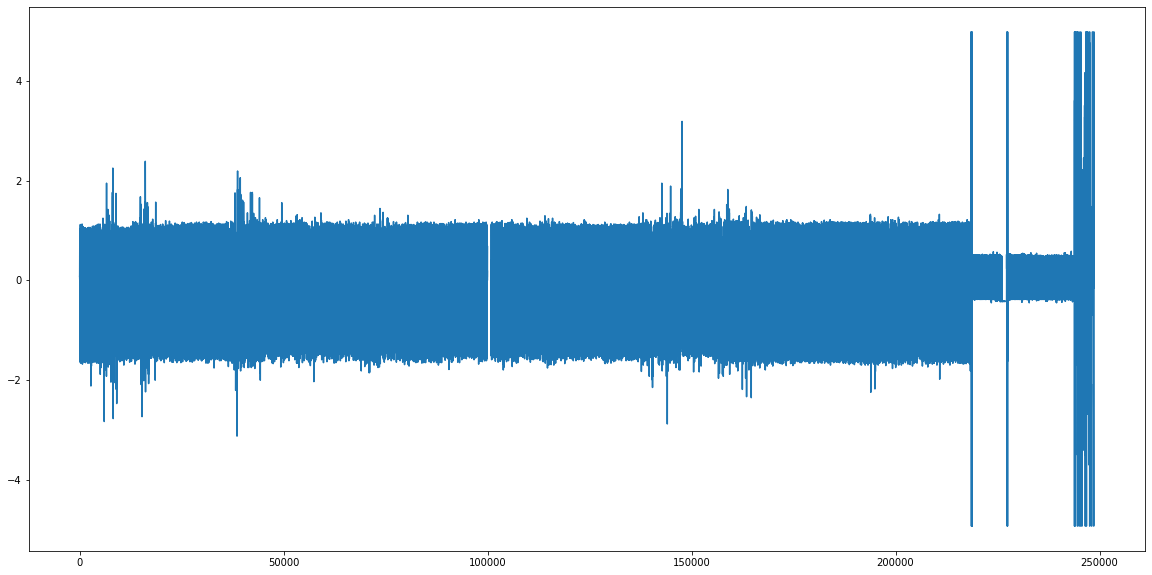

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(vfile_ecg[0])

In [32]:
import sys
sys.path.append(os.path.dirname(os.path.abspath('../pyvital2')))
from pyvital2 import vitaldb as vitaldb0

In [51]:
df_match = pd.read_csv('ftn+_age_match_20201224-Copy1.csv',sep=',')
df_match['NRS_time']=pd.to_datetime(df_match['NRS_time'])
df_match = df_match.rename(columns={'Unnamed: 0':'index'})
#df_match.reset_index(inplace=True, drop=True)

print(len(df_match))

srate= 100
for i in range(len(df_match)):
    filename = str(df_match.loc[i,'Value'])+','+str(df_match.loc[i,'index'])+','+ df_match.loc[i,'path']
    if True:
        print(i, end=' ')
        i = 1890
        rec_path = '../../../cranberry2/Preprocessing/vital_data/pacu_full_vital/'+ 'PACU1_2_190828_105401.vital'#df_match.loc[i,'path']
        print(rec_path)
        #print('1')
        vfile_ecg = vitaldb.vital_recs_time(rec_path,['SNUADCW/ECG_II'],interval=0.01).flatten()
        vfile_ppg = vitaldb.vital_recs_time(rec_path,['SNUADCW/PLETH'],interval=0.01).flatten()

        #print(vfile)
        if len(vfile_ecg[0])==0 | len(vfile_ppg[0])==0:
            print('index ',df_match.loc[i,'index'],' OPID ',df_match.loc[i,'opid'],'empty vital file')
        else:
            Abs_time = [vfile_ecg[1]+datetime.timedelta(hours=9)+datetime.timedelta(seconds=i/srate) for i in range(len(vfile_ecg[0]))]
            #print(vfile[1])
            dics = {'Abs_time':Abs_time,'PPG':vfile_ppg[0],'ECG':vfile_ecg[0]}
            df_vital = pd.DataFrame(data=dics)
            end_idx_list = df_vital[(df_vital['Abs_time'] > df_match.loc[i,'NRS_time'] - datetime.timedelta(seconds=1)) & (df_vital['Abs_time'] < df_match.loc[i,'NRS_time'] + datetime.timedelta(seconds=1))].index.tolist()

            if len(end_idx_list)==0:
                print('index ',i,' OPID ',df_match.loc[i,'opid']," no vital data at NRS time")

            else:
                end_idx=end_idx_list[0]+1
                start_idx= end_idx - 5 * 60 * srate
                start_idx_n = max(0,start_idx)


                ext = df_vital[start_idx_n:end_idx]
                extr=ext.dropna(subset=['ECG'])
                extr=extr.drop_duplicates(subset=['ECG'])

                if len(extr)>1:
                    if start_idx <0 :
                        fit = (-1)*end_idx 
                        extraction = pd.DataFrame(index=range(5*60*srate),columns=['Abs_time','PPG','ECG'])
                        extraction[fit:]=ext
                        

                    else:
                        extraction = ext
            break

10156
0 ../../../cranberry2/Preprocessing/vital_data/pacu_full_vital/PACU1_2_190828_105401.vital


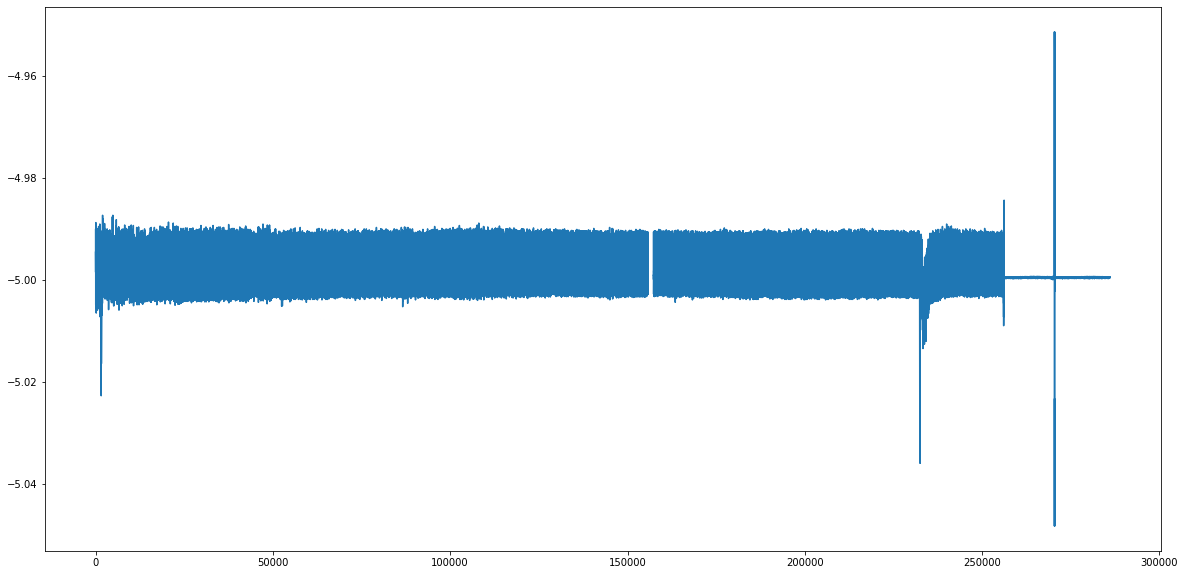

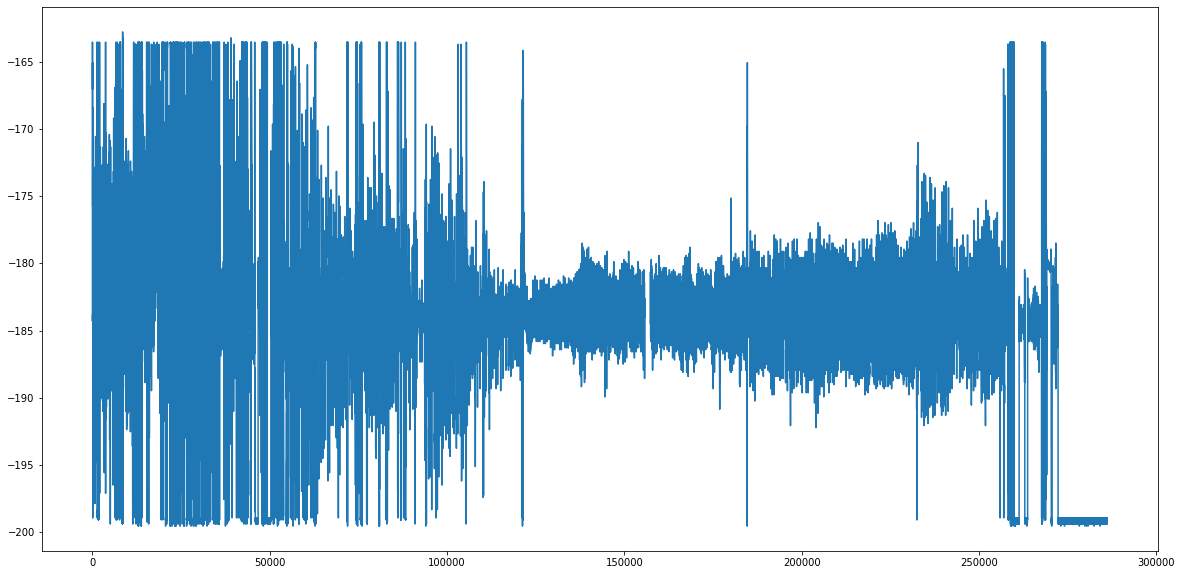

In [52]:
plt.figure(figsize=(20,10))
plt.plot(vfile_ecg[0])

plt.figure(figsize=(20,10))
plt.plot(vfile_ppg[0])

In [74]:
df_match[df_match['path']=='PACU1_5_190607_122953.vital']

,index,oID,hid,gender,birthdate,NRS_time,Value,bed,opend_time,opid,path,opday,age_year
795,801,22930744,38594290,F,1943-03-04 00:00:00,2019-06-07 13:00:00,2.0,5,2019-06-07 12:14:00,190607057,PACU1_5_190607_122953.vital,2019-06-07 00:00:00,76


In [25]:
df_match[df_match['path']=='PACU1_2_190828_105401.vital']

,index,oID,hid,gender,birthdate,NRS_time,Value,bed,opend_time,opid,path,opday,age_year
1890,1902,24370599,52716863,F,1981-01-30 00:00:00,2019-08-28 10:55:00,5.0,2,2019-08-28 10:40:00,190828045,PACU1_2_190828_105401.vital,2019-08-28 00:00:00,38
1891,1903,24370599,52716863,F,1981-01-30 00:00:00,2019-08-28 11:11:00,7.0,2,2019-08-28 10:40:00,190828045,PACU1_2_190828_105401.vital,2019-08-28 00:00:00,38
8898,8963,24370599,52716863,F,1981-01-30 00:00:00,2019-08-28 11:30:00,4.0,2,2019-08-28 10:40:00,190828045,PACU1_2_190828_105401.vital,2019-08-28 00:00:00,38


In [19]:
df_match.loc[i]

index                                   0
oID                              21863852
hid                              51597829
gender                                  F
birthdate             1998-08-13 00:00:00
NRS_time              2019-04-08 12:00:00
Value                                   6
bed                                     1
opend_time            2019-04-08 11:39:00
opid                            190408044
path          PACU1_1_190408_115004.vital
opday                 2019-04-08 00:00:00
age_year                               20
Name: 0, dtype: object

# NIBP PACU pickle로 저장하기

In [ ]:
import pandas as pd
import datetime
import time
import pickle
import os
import numpy as np
import vitaldb

df_match = pd.read_csv('ftn+_age_match_20201224-Copy1.csv',sep=',')
df_match['NRS_time']=pd.to_datetime(df_match['NRS_time'])
df_match = df_match.rename(columns={'Unnamed: 0':'index'})
#df_match.reset_index(inplace=True, drop=True)
'''vital -> csv
df_match['path']=[f_name.split('.')[0]+".csv" for f_name in df_match['path'].values.flatten()] '''

save_path = '../../../cranberry2/Preprocessing/vital_data/NIBP_250Hz_preop_5min/'
if not os.path.exists(save_path[:-1]):
    os.mkdir(save_path[:-1])
    
srate= 250
for i in range(len(df_match)):
    filename = str(df_match.loc[i,'Value'])+','+str(df_match.loc[i,'index'])+','+ df_match.loc[i,'path']
    if not os.path.exists(save_path+filename):
        print(i,'...', end=' ')
        rec_path = '../../../cranberry2/Preprocessing/vital_data/pacu_full_vital/'+df_match.loc[i,'path']    
        vfile = vitaldb.vital_recs_time(rec_path,['Solar8000/NIBP_MBP'],interval=0.004).flatten()
        
        if len(vfile[0])==0:
            print('index ',i,' OPID ',df_match.loc[i,'opid'],'empty NIBP')
        else:
            Abs_time = [vfile[1]+datetime.timedelta(hours=9)+datetime.timedelta(seconds=j/srate) for j in range(len(vfile[0]))]
            dics = {'Abs_time':Abs_time,'NIBP':vfile[0]}
            df_NIBP = pd.DataFrame(data=dics)
            end_idx_list = df_NIBP[(df_NIBP['Abs_time'] > df_match.loc[i,'NRS_time'] - datetime.timedelta(seconds=1)) & (df_NIBP['Abs_time'] < df_match.loc[i,'NRS_time'] + datetime.timedelta(seconds=1))].index.tolist()

            if len(end_idx_list)==0:
                print('index ',i,' OPID ',df_match.loc[i,'opid']," no vital data at NRS time")                  
            else:
                end_idx=end_idx_list[0]
                start_idx= max(0,end_idx - 5 * 60 * srate)
                extraction = df_NIBP[start_idx:end_idx]
                with open(save_path+filename,'wb') as f:
                    pickle.dump(extraction, f)
                    print('done')

#이건 2분보다 짧아도 저장함

0 ... done
1 ... done
2 ... done
3 ... done
4 ... done
5 ... done
6 ... done
7 ... done
8 ... done
9 ... done
10 ... done
11 ... done
12 ... done
13 ... done
14 ... done
15 ... done
16 ... done
17 ... done
18 ... done
19 ... done
20 ... done
21 ... done
22 ... done
23 ... done
24 ... done
25 ... done
26 ... done
27 ... done
28 ... done
29 ... done
30 ... done
31 ... done
32 ... done
33 ... done
34 ... done
35 ... done
36 ... done
37 ... done
38 ... done
39 ... done
40 ... done
41 ... done
42 ... done
43 ... done
44 ... done
45 ... done
46 ... done
47 ... done
48 ... done
49 ... done
50 ... done
51 ... done
52 ... done
53 ... done
54 ... done
55 ... done
56 ... done
57 ... done
58 ... done
59 ... done
60 ... done
61 ... done
62 ... done
63 ... done
64 ... done
65 ... done
66 ... done
67 ... done
68 ... done
69 ... done
70 ... done
71 ... done
72 ... done
73 ... done
74 ... done
75 ... done
76 ... done
77 ... done
78 ... done
79 ... done
80 ... done
81 ... done
82 ... done
83 ... done
84

639 ... done
640 ... done
641 ... done
642 ... done
643 ... done
644 ... done
645 ... done
646 ... done
647 ... done
648 ... done
649 ... done
650 ... done
651 ... done
652 ... done
653 ... done
654 ... done
655 ... done
656 ... done
657 ... done
658 ... done
659 ... done
660 ... done
661 ... done
662 ... done
663 ... done
664 ... done
665 ... done
666 ... done
667 ... done
668 ... done
669 ... done
670 ... done
671 ... done
672 ... done
673 ... done
674 ... done
675 ... done
676 ... done
677 ... done
678 ... done
679 ... done
680 ... done
681 ... done
682 ... done
683 ... done
684 ... done
685 ... done
686 ... done
687 ... done
688 ... done
689 ... done
690 ... done
691 ... done
692 ... done
693 ... done
694 ... done
695 ... done
696 ... done
697 ... done
698 ... done
699 ... done
700 ... done
701 ... done
702 ... done
703 ... done
704 ... done
705 ... done
706 ... done
707 ... done
708 ... done
709 ... done
710 ... done
711 ... done
712 ... done
713 ... done
714 ... done
715 ... done

# NIBP preop pickle로 저장하기

In [ ]:
import pandas as pd
import datetime
import time
import pickle
import os
import numpy as np
from pyvital2 import vitaldb

df_match = pd.read_csv('ftn+_age_match_20201224-Copy1.csv',sep=',')
df_match['NRS_time']=pd.to_datetime(df_match['NRS_time'])
df_match = df_match.rename(columns={'Unnamed: 0':'index'})
#df_match.reset_index(inplace=True, drop=True)


'''df_IDpath 불러야 함'''


for i in range(len(df_IDpath)):
    #try: 
    #opid match
    idx_list = df_match[df_match['opid']==df_IDpath.loc[j,'opid']].index.tolist()
    i = min(idx_list)

    rec_path = 'preop_vital/preop_vital/' + df_IDpath.loc[j,'fileid']
    df_IDpath.loc[j, 'file_path'] = df_match.loc[i, 'path']
    df_IDpath.loc[j, 'NRS'] = df_match.loc[i, 'Value']
    df_IDpath.loc[j, 'NRS_time'] = df_match.loc[i, 'NRS_time']
print(df_IDpath)
print(df_match)

In [ ]:
import pandas as pd
import pickle
import datetime
import time
from pyvital2 import vitaldb
import numpy as np
import os

'''vital -> csv
df_match['path']=[f_name.split('.')[0]+".csv" for f_name in df_match['path'].values.flatten()] '''

srate= 250
for i in range(len(df_IDpath)):
    filename = df_IDpath.loc[i,'file_path']
    if not os.path.exists('vital_data/NIBP_250Hz_preop_2min_pickle/'+filename):
        rec_path = 'preop_vital/preop_vital/'+ df_IDpath.loc[i,'fileid']
        vfile = vitaldb.vital_recs(rec_path,['Solar8000/NIBP_MBP'],interval=0.004).flatten()[0:2*60*250]

        #print(vfile)
        if len(vfile) ==0 :
            print('index ',i,' OPID ',df_IDpath.loc[i,'opid'],'empty NIBP')
        else:
            dics = {'NIBP':vfile}
            df_NIBP = pd.DataFrame(data=dics)

            extraction = df_NIBP
            with open('vital_data/NIBP_250Hz_preop_2min_pickle/'+filename,'wb') as f:
                pickle.dump(extraction, f)
            print(i,'/',len(df_IDpath),' save')